<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Otimizando o Modelo de IA Para  Prever a Capacidade com Stacked LSTM</font></b></strong>

No modelo anterior criamos nosso primeiro modelo de Deep Learning para a Previsão da Capacidade. Agora vamos trabalhar na otimização do modelo e começaremos com um modelo Stacked LSTM.

**Deep Learning - Modelo Stacked LSTM**

O Modelo Stacked LSTM nada mais é do que um Modelo com mais de uma camada LSTM. A camada LSTM é o diferencial do modelo e adicionando mais uma camada esperamos aumentar o poder de acurácia do modelo final.

Vamos discutir ainda como calcular o número de neurônios em cada camada. 

Este modelo considera algum conhecimento em Deep Learning e esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [2]:
# Imports para modelagem preditiva - Tensorflow 1.
#import keras
#from keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
#from keras.layers.core import Dense, Activation
#from keras.layers import LSTM
#from keras.layers import Dropout

In [3]:
# Imports para modelagem preditiva - Tensorflow 2.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

sklearn               0.23.1
statsmodels           0.11.1
tensorflow            2.0.0
pandas                1.0.5
numpy                 1.16.6
statsmodels.api       0.11.1
matplotlib            3.3.0
seaborn               0.10.1
tensorflow_core.keras 2.2.4-tf
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [5]:
# Carrega os dados
dataframe = pd.read_csv("Arrecadacao_icms.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [6]:
# Dados
dataframe.head()

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702


In [7]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['Arrecadacao']

In [8]:
# Random seed 
np.random.seed(7)

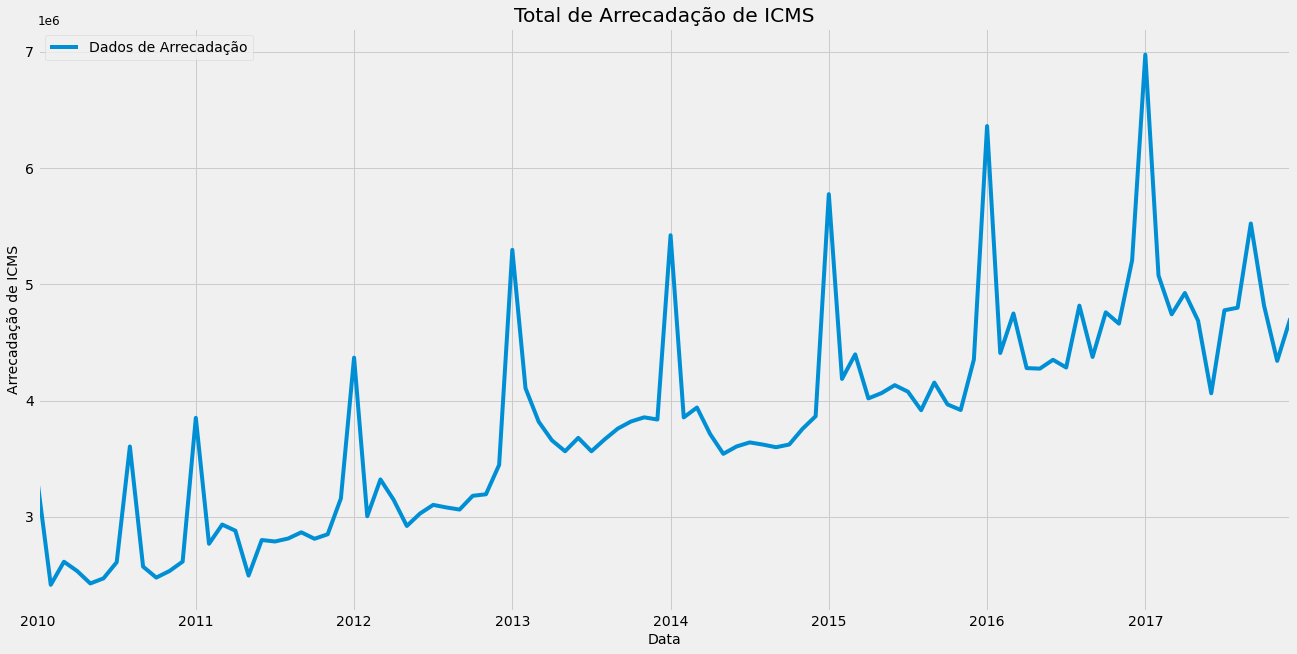

In [9]:
# Plot
target.plot(title = 'Total de Arrecadação de ICMS', fontsize = 14, label = 'Dados de Arrecadação') 
plt.xlabel("Data") 
plt.ylabel("Arrecadação de ICMS") 
plt.legend(loc = 'best') 
plt.show()

In [10]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

72 24


In [11]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.values.reshape(-1,1)
testset = teste.values.reshape(-1,1)

### Função Para o Cálculo da Acurácia

In [12]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo Stacked LSTM

A rede Long Short-Term Memory, ou LSTM, é uma rede neural recorrente treinada usando Backpropagation Through Time e supera o problema da dissipação do gradiente (isso é explicado no Deep Learning Book).

Como tal, o modelo pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.

Podemos alterar a arquitetura do modelo e adicionar mais uma camada LSTM, aumentando assim a capacidade de previsão do modelo.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entre 0 e 1. O parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intevalo será entre 0 e 1.

In [13]:
# Cria o scaler para dimensionar nossos dados entre 0 e 1
scaler = MinMaxScaler()

In [14]:
# Treina o scaler nos dados de treino (nunca no dataset completo ou nos dados de teste)
scaler.fit(trainset)

MinMaxScaler()

In [15]:
# Aplica o mesmo scaler aos dados de treino 
# (Não precisamos aplicar aos dados de teste, pois vamos converter a saída das previsões antes de avaliar o modelo)
trainset = scaler.transform(trainset)

In [16]:
trainset.shape

(72, 1)

Aqui definimos os hiperparâmetros.

In [17]:
# Número de repetições
n_rep = 5

# Número de epochs
num_epochs = 200

# Número de inputs (usaremos 24 séries para prever as 24 séries seguintes)
n_input = 24

# Comprimento das sequências de saída (em número de timesteps)
n_output = 24

# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 10

O TimeseriesGenerator do Keras transforma automaticamente um conjunto de dados univariado de séries temporais em um dataset para problema de aprendizado supervisionado.

https://keras.io/preprocessing/sequence/

In [18]:
# Generator
generator = TimeseriesGenerator(trainset, 
                                trainset, 
                                length = n_output,
                                batch_size = size_batch)

Podemos agora criar o modelo Stacked LSTM.

Detalhes sobre os hiperparâmetros aqui:

https://keras.io/layers/recurrent/

In [19]:
# Criação e treinamento do modelo LSTM Padrão
start = time()

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Podemos adicionar agora a primeira camada da rede, ou camada de entrada.
    # Esta é a camada que recebe os dados.
    # Como vamos criar uma arquitetura de camadas LSTM em pilha, precisamos adicionar o parâmetro:
    # return_sequences = True, indicando que esta camada deve retornar uma sequência que será usada
    # como entrada na próxima camada LSTM
    modelo_lstm.add(LSTM(40, activation = 'tanh', return_sequences = True, input_shape = (n_input, n_features)))
    
    # Mais uma camada LSTM
    modelo_lstm.add(LSTM(40, activation = 'relu'))
    
    # Adicionamos a primeira camada intermediária ou oculta
    modelo_lstm.add(Dense(50, activation = 'relu'))
    
    # Adicionamos a segunda camada intermediária ou oculta
    modelo_lstm.add(Dense(50, activation = 'relu'))
    
    # Adicionamos a camada de saída e tudo que precisamos é de 1 neurônio pois estamos prevendo apenas 1 valor.
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    # adam = optimizers.Adam(learning_rate = 0.001)
    adam = optimizers.Adam(lr = 0.001)
    modelo_lstm.compile(optimizer = adam, loss = 'mean_squared_error')
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = target[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/200
5/5 [==============================] - 3s 638ms/step - loss: 0.1974
Epoch 2/200
5/5 [==============================] - 1s 101ms/step - loss: 0.1650
Epoch 3/200
5/5 [==============================] - 1s 120ms/step - loss: 0.1291
Epoch 4/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0707
Epoch 5/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0291
Epoch 6/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0714
Epoch 7/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0256
Epoch 8/200
5/5 [==============================] - 1s 106ms/step - loss: 0.0384
Epoch 9/200
5/5 [==============================] - 1s 106ms/step - loss: 0.0400
Epoch 10/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0339
Epoch 11/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0262
Epoch 12/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0228
Epoch 13/200
5/5 [===================

Epoch 102/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0227
Epoch 103/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0226
Epoch 104/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0230
Epoch 105/200
5/5 [==============================] - 1s 106ms/step - loss: 0.0234
Epoch 106/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0225
Epoch 107/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0231
Epoch 108/200
5/5 [==============================] - 1s 106ms/step - loss: 0.0232
Epoch 109/200
5/5 [==============================] - 1s 106ms/step - loss: 0.0225
Epoch 110/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0226
Epoch 111/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0228
Epoch 112/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0227
Epoch 113/200
5/5 [==============================] - 1s 105ms/step - loss: 0.0228
Epoch 114/200
5/

Epoch 2/200
5/5 [==============================] - 1s 103ms/step - loss: 0.1221
Epoch 3/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0513
Epoch 4/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0386
Epoch 5/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0325
Epoch 6/200
5/5 [==============================] - 1s 123ms/step - loss: 0.0277
Epoch 7/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0314
Epoch 8/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0272
Epoch 9/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0243
Epoch 10/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0247
Epoch 11/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0234
Epoch 12/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0235
Epoch 13/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0238
Epoch 14/200
5/5 [==================

5/5 [==============================] - 1s 103ms/step - loss: 0.1362
Epoch 3/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0881
Epoch 4/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0333
Epoch 5/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0380
Epoch 6/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0241
Epoch 7/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0287
Epoch 8/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0280
Epoch 9/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0242
Epoch 10/200
5/5 [==============================] - 1s 107ms/step - loss: 0.0240
Epoch 11/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0242
Epoch 12/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0238
Epoch 13/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0239
Epoch 14/200
5/5 [==============================

5/5 [==============================] - 1s 103ms/step - loss: 0.1570
Epoch 3/200
5/5 [==============================] - 1s 103ms/step - loss: 0.1197
Epoch 4/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0619
Epoch 5/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0309
Epoch 6/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0293
Epoch 7/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0268
Epoch 8/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0283
Epoch 9/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0254
Epoch 10/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0246
Epoch 11/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0242
Epoch 12/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0241
Epoch 13/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0241
Epoch 14/200
5/5 [==============================

Epoch 3/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0407
Epoch 4/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0323
Epoch 5/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0254
Epoch 6/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0257
Epoch 7/200
5/5 [==============================] - 1s 104ms/step - loss: 0.0242
Epoch 8/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0241
Epoch 9/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0243
Epoch 10/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0234
Epoch 11/200
5/5 [==============================] - 1s 103ms/step - loss: 0.0235
Epoch 12/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0235
Epoch 13/200
5/5 [==============================] - 1s 131ms/step - loss: 0.0235
Epoch 14/200
5/5 [==============================] - 1s 102ms/step - loss: 0.0237
Epoch 15/200
5/5 [=================

O mais delicado na criação do modelo é definir o input_shape da primeira camada. É isso que o modelo espera como entrada para cada amostra em termos do número de etapas de tempo e do número de recursos.

Estamos trabalhando com uma série univariada, portanto, o número de recursos é um, para uma variável.

O número de etapas de tempo como entrada é o número que escolhemos para prever as sequências de saída. Em nosso exemplo, estamos usando 24 sequências para prever 24 sequências.

Quase sempre temos várias amostras; portanto, o modelo espera que o componente de entrada dos dados de treinamento tenha as dimensões ou a forma:

[samples, timesteps, features]

Em nosso exemplo, nós temos:

- samples = n_rep (20)
- timesteps = n_input (24)
- features = n_features (1)

Agora calculamos o erro modelo.

In [20]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [21]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [22]:
# Previsões finais
#resultado_final

In [23]:
# Ajustamos o shape
resultado_final = resultado_final.reshape((24,))

In [24]:
# Previsões finais
resultado_final

array([4444483.03263304, 4127598.25839243, 4090271.02253075,
       4007370.16932645, 3974624.32770529, 3995707.635762  ,
       4006504.12206075, 4011564.14402761, 4027030.80987997,
       4083456.31924107, 4189217.36816504, 4344360.13142228,
       4599721.78975382, 4258409.42061624, 4264957.14723039,
       4163650.26163144, 4162098.52102764, 4161119.86018486,
       4135729.8837549 , 4111231.92539601, 4144346.3442066 ,
       4114835.49979131, 4128486.67218828, 4230368.8802084 ])

In [25]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)

MSE das previsões é 894496340641.3424
RMSE das previsões é 945778.1667
MAPE das previsões é 13.1198


Conseguimos reduzir o RMSE, mas aumentamos o MAPE.

Não é fácil ajustar um modelo de previsão de série temporal. De fato, trouxemos uma série difícil mesmo (média mensal de vendas) para demonstrar as complicações envolvidas em todo o processo.

Estamos procurando fazer poucas mudanças de uma aula para outra, para ajudar você a comparar os modelos. Mas fique à vontade para mudar os hiperparâmetros e tentar chegar ao melhor modelo.

Vamos continuar em busca do modelo ideal para prever nossas vendas. Ainda tenho algumas cartas na manga. Como é mesmo que se diz? Ahh...sim: "quanto mais ferramentas você sabe, mais problemas é capaz de resolver".

Abaixo o plot das previsões.

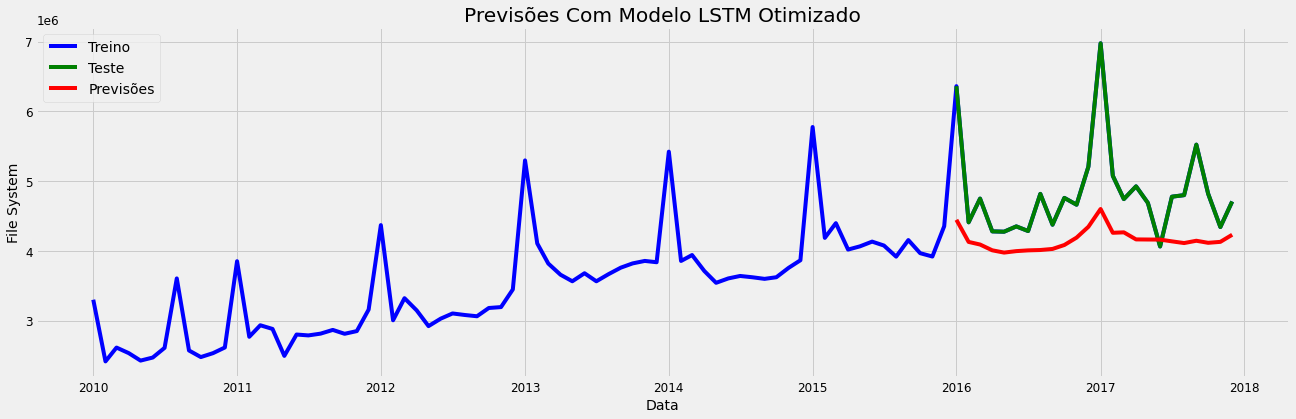

In [26]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(target.index, target.values, label = 'Treino', color = 'Blue')
plt.plot(teste, label = 'Teste', color = 'green')

# Previsões
plt.plot(target[72:].index, resultado_final, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo LSTM Otimizado')
plt.xlabel('Data')
plt.ylabel('File System')
plt.legend(loc = 'upper left')
plt.show()

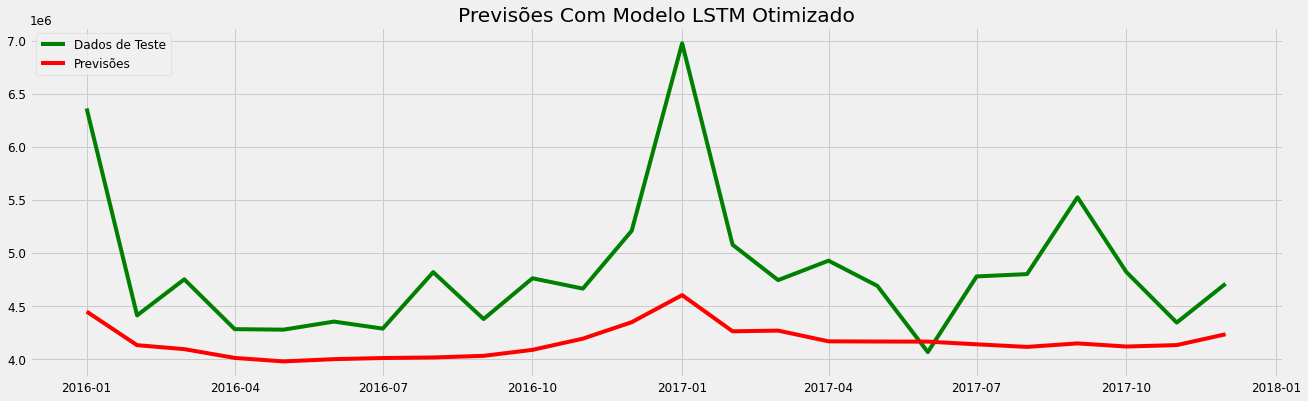

In [27]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[72:].index, resultado_final, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Otimizado')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Vamos fazer o Forecasting para 2 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [28]:
# Última data da série
target.index[-1]

Timestamp('2017-12-01 00:00:00')

In [29]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(months = x) for x in range(0, 25)]

In [30]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [31]:
# Nossa série original é um objeto do tipo pd.Series
#type(target)

In [32]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [33]:
# Visualiza os dados
#df_original.head()

In [34]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [35]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
#data_futuras

In [36]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [37]:
# Concatenamos a série original com os valores de forecasting de 41 dias além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [38]:
# Visualiza o dataframe
df_forecasting

,Arrecadacao,Prediction
2010-01-01,3299311.0,NaN
2010-02-01,2415158.0,NaN
2010-03-01,2613292.0,NaN
2010-04-01,2533679.0,NaN
2010-05-01,2426702.0,NaN
...,...,...
2019-08-01,NaN,4.117014e+06
2019-09-01,NaN,4.124851e+06
2019-10-01,NaN,4.103810e+06
2019-11-01,NaN,4.103859e+06


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste. 
Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 2 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Vamos colocar o forecasting em um Plot.

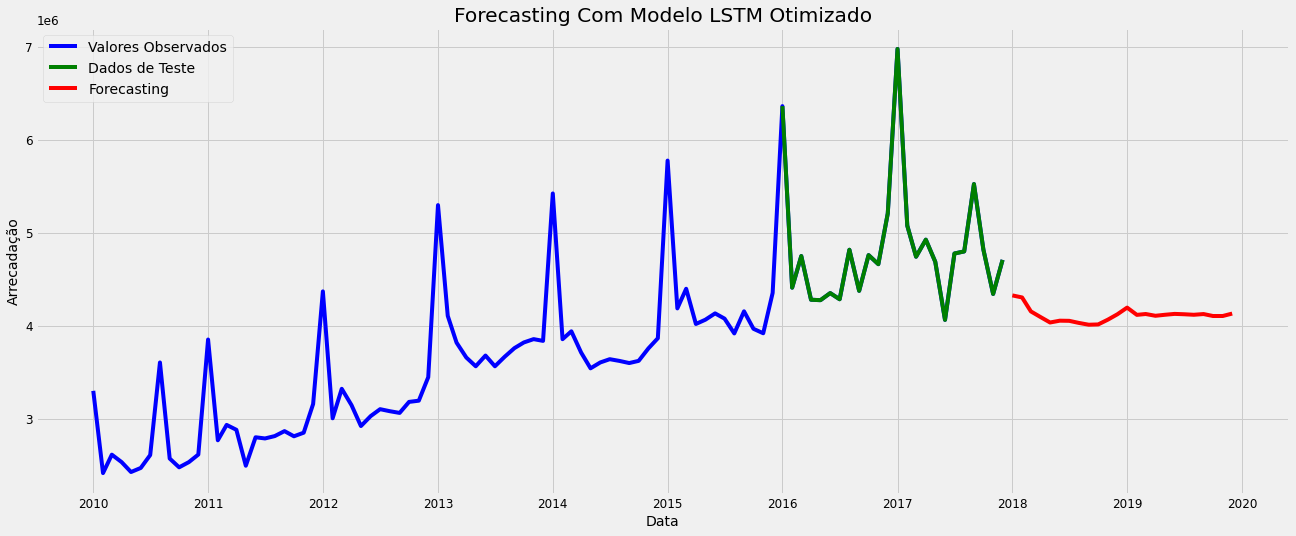

In [40]:
# Plot
plt.figure(figsize = (20, 8))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Otimizado')
plt.xlabel('Data')
plt.ylabel('Arrecadação')
plt.legend(loc = 'upper left')
plt.show()

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (12,9) - AIC = 2044.48 e RMSE = 706415.3914
- Modelo 16 --> Modelo ARIMA (2,1,1) - AIC = 2106,43 e RMSE = 1099391.3958
- Modelo 17 --> Modelo SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC = 1251.06 e RMSE = 332666.2626
- Modelo 18 --> Modelo SARIMA(0, 1, 1)x(0, 1, 1, 12) - AIC = 1233.47 e RMSE = 336782.4202
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 15.8048 e RMSE = 1037107.0089   -   (5 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 11.7861 e RMSE = 878868.4191   -   (20 repetições)
- Modelo 23 --> Modelo Stacked LSTM - MAPE = 13.1198 e RMSE = 945778.1667

Vamos seguir otimizando nossa rede LSTM e ver até onde conseguimos ir com essa arquitetura.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim